In [1]:
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from grid_criticality import analysis_path, path_pr, get_distances
from sweep import get_script
from grid_postprocessing import p_list, r_list

import plot_utils as pu

In [2]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)
ioi = 976
poi = delta_p.loc[ioi, 'p_inh']
roi = delta_p.loc[ioi, 'r_inh']
runseed = delta_p.loc[ioi, 'runseed']
net = delta_p.loc[ioi, 'net']

In [3]:
script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{path_pr(poi)}_rinh_{path_pr(roi)}_runseed_{runseed}')

distances = get_distances(script, path)

W_stats = dd.io.load(f'{path}/W_stats2.h5')
W_matrix = W_stats['matrix']

N, N_nets = script.params['N'], script.params['N_nets']
inh_ratio = script.params.get('inhibitory_ratio', 0.2)
N_exc = int(N*(1-inh_ratio))
N_inh = N - N_exc

In [4]:
def get_global_idx(net, local_idx):
    if local_idx < N_exc:
        return net*N_exc + local_idx
    else:
        return N_nets*N_exc + net*N_inh + local_idx-N_exc

In [5]:
def get_coincidence_single(tpre, tpost, delay, dt_max):
    ipost = 0
    t0 = int(dt_max/1e-3)
    coincidence = np.zeros(1 + 2*t0, int)
    for t in tpre + delay:  # Presynaptic spike arrival times

        # Forward ipost through old spikes
        while ipost < len(tpost) and tpost[ipost] < t - dt_max:
            ipost += 1

        # Run jpost through all spikes in the coincidence window (+- dt_max)
        for jpost in range(ipost, len(tpost)):
            if tpost[jpost] > t + dt_max:
                break
            dt = tpost[jpost] - t  # dt := post minus pre
            coincidence[t0 + int(dt/1e-3)] += 1
    return coincidence

In [6]:
dt_max = 50e-3  # s
velocity = .15  # m/s
slice_size = 5  # minutes

coincidences = {}
coincidences_nodelay = {}
for iteration in range(script.iterations):
    spikes = dd.io.load(f'{path}/spikes_{iteration}.h5')

    for pre in range(80, 100):
        if pre not in coincidences:
            coincidences[pre] = {}
            coincidences_nodelay[pre] = {}
        gpre = get_global_idx(net, pre)
        mpre = spikes['i'] == gpre
        tpre = spikes['t'][mpre]

        for post in range(100):
            if np.isnan(W_matrix[net][0][pre, post]):
                continue
            if post not in coincidences[pre]:
                coincidences[pre][post] = []
                coincidences_nodelay[pre][post] = []

            delay = int(np.ceil(distances[net][pre, post] / velocity)) * 1e-3  # s
            gpost = get_global_idx(net, post)
            mpost = spikes['i'] == gpost
            tpost = spikes['t'][mpost]

            for islice in range(60//slice_size):
                tpre_slice = tpre[(tpre >= islice*5*60) & (tpre < (islice+1)*5*60)]
                tpost_slice = tpost[(tpost >= islice*5*60 - dt_max) & (tpost < (islice+1)*5*60 + delay + dt_max)]

                coincidence = get_coincidence_single(tpre_slice, tpost_slice, delay, dt_max)
                coincidences[pre][post].append(coincidence)

                coincidence = get_coincidence_single(tpre_slice, tpost_slice, 0, dt_max)
                coincidences_nodelay[pre][post].append(coincidence)

In [7]:
DT = 1e-3
y = np.arange(-dt_max, dt_max+1e-6, DT)
y[np.argmin(np.abs(y))] = 0  # rather than some floating point error.
nearly_sync = np.abs(y) < 5.5*DT
zerocrossing = 13.9e-3  # iSTDP zero-crossing point (s)
cut1 = np.argmin(np.abs(y + zerocrossing))+1
cut2 = np.argmin(np.abs(y - zerocrossing))
y_heatmap = np.concatenate([y[:cut1], [-zerocrossing], y[cut1:cut2], [zerocrossing], y[cut2:]])

In [8]:
x = np.arange(0, len(W_matrix[net])*slice_size/60, slice_size/60)

In [9]:
nbins = 4
r_bins = np.arange(1,nbins,1)
def r_bin_label(bin, r_bins=r_bins):
    return f'${r_bins[bin-1] if bin>0 else 0} < r \leq {r_bins[bin] if bin<len(r_bins) else 4}$ mm'

In [10]:
binned_dist = np.digitize(distances[net], r_bins, right=True)
bin_dist_coincidences = np.zeros((nbins, len(W_matrix[net]), len(y)))
bin_dist_coincidences_nodelay = np.zeros_like(bin_dist_coincidences)
bin_dist_weights = np.zeros((nbins, len(W_matrix[net])))
n = np.zeros(nbins)
for bin in range(nbins):
    for pre, post in zip(*np.nonzero((binned_dist==bin) & ~np.isnan(W_matrix[net][0]))):
        if pre < N_exc:
            continue
        bin_dist_coincidences[bin] += np.asarray(coincidences[pre][post])
        bin_dist_coincidences_nodelay[bin] += np.asarray(coincidences_nodelay[pre][post])
        bin_dist_weights[bin] += np.asarray([w[pre,post] for w in W_matrix[net]])
        n[bin] += 1
bin_dist_coincidences /= n[:, None, None]
bin_dist_coincidences_nodelay /= n[:, None, None]
bin_dist_weights /= n[:, None]

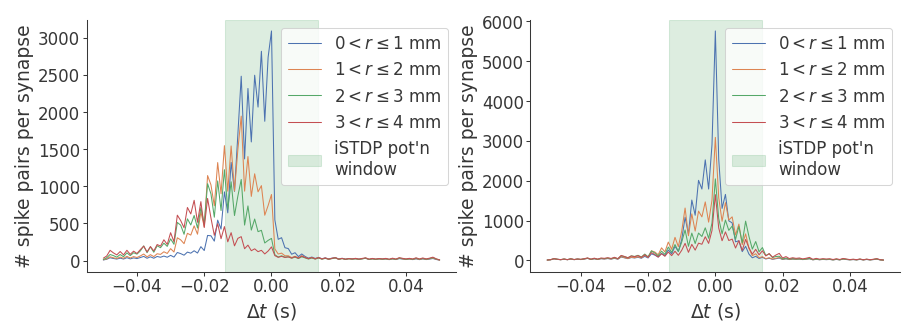

In [11]:
def plot_coincidence_curves(ax, coincidences):
    for i, c in enumerate(coincidences):
        ax.plot(y, c.sum(0), label=r_bin_label(i))

    ax.axvspan(-zerocrossing, zerocrossing, color='g', alpha=.2, label='iSTDP pot\'n\nwindow')

    ax.legend()
    ax.set_xlabel('$\Delta t$ (s)')
    ax.set_ylabel('# spike pairs per synapse')

    sns.despine(ax=ax)

fig, axs = plt.subplots(1,2, figsize=pu.fullwidth(2), dpi=150)
plot_coincidence_curves(axs[0], bin_dist_coincidences)
plot_coincidence_curves(axs[1], bin_dist_coincidences_nodelay)

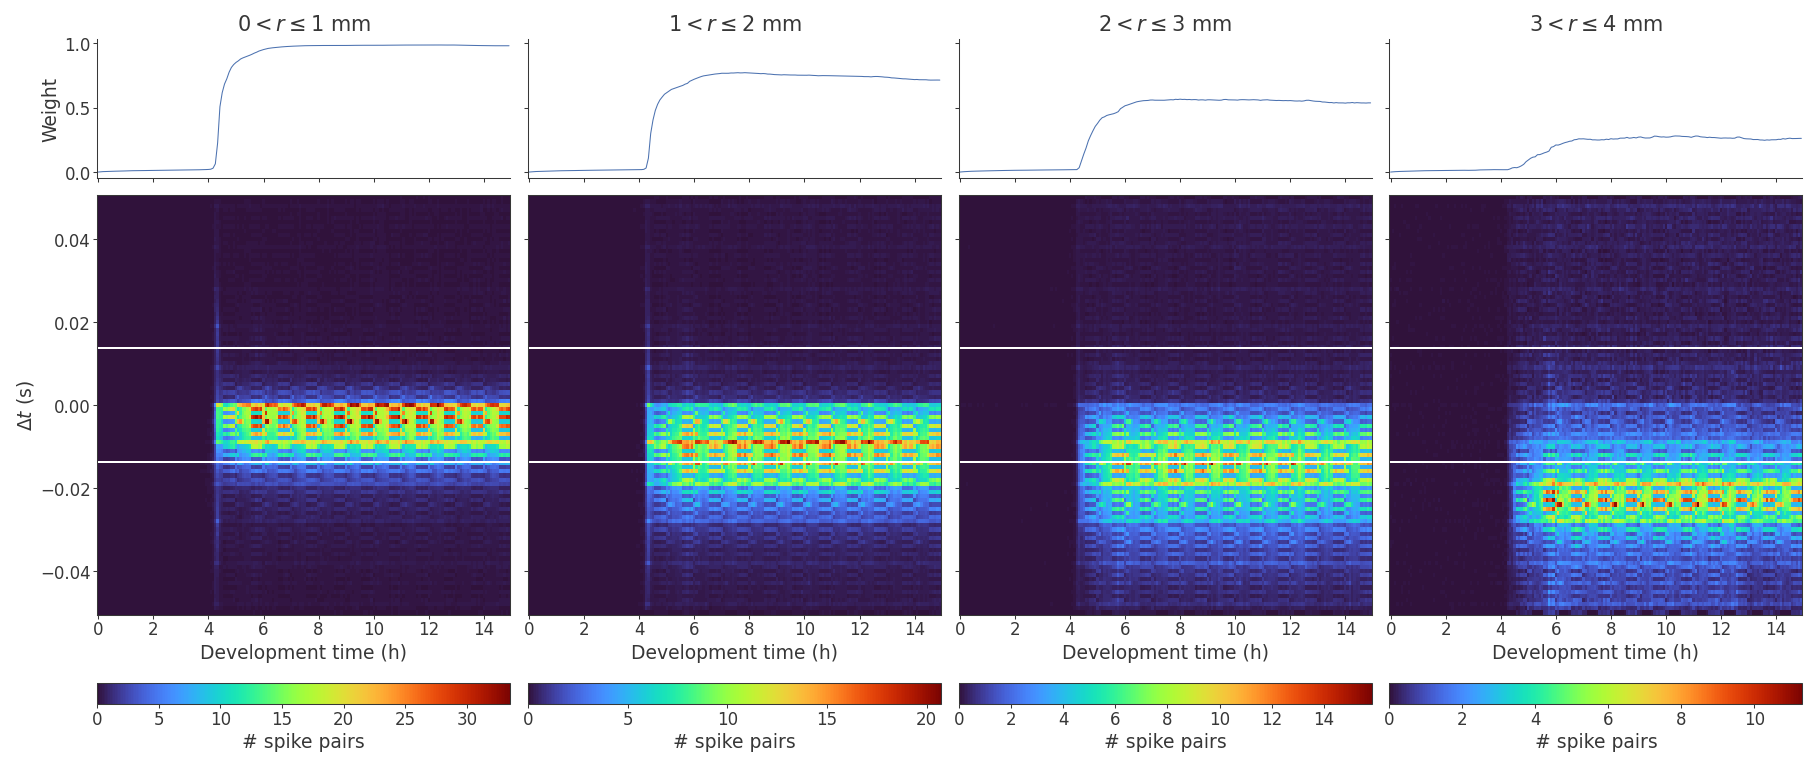

In [12]:
def plot_coincidences(fig):
    axs = fig.subplots(2, nbins, height_ratios=(1,3), sharex=True, sharey='row')

    for i, (c, w, axc) in enumerate(zip(bin_dist_coincidences, bin_dist_weights, axs.T)):
        c = c.T
        c = np.concatenate([c[:cut1], np.full((1,len(c[0])), np.nan), c[cut1:cut2], np.full((1,len(c[0])), np.nan), c[cut2:]])
        m = axc[1].pcolormesh(x, y_heatmap, c, cmap='turbo', rasterized=True)
        plt.colorbar(m, ax=axc[1], label='# spike pairs', orientation='horizontal')
        axc[1].set_xlabel('Development time (h)')

        axc[0].set_title(r_bin_label(i))
        axc[0].plot(x, w)

        sns.despine(ax=axc[0])

    axs[0,0].set_ylabel('Weight')
    axs[1,0].set_ylabel('$\Delta t$ (s)')
    return axs

fig = plt.figure(figsize=(3*nbins,5), dpi=150, layout='compressed')
plot_coincidences(fig);

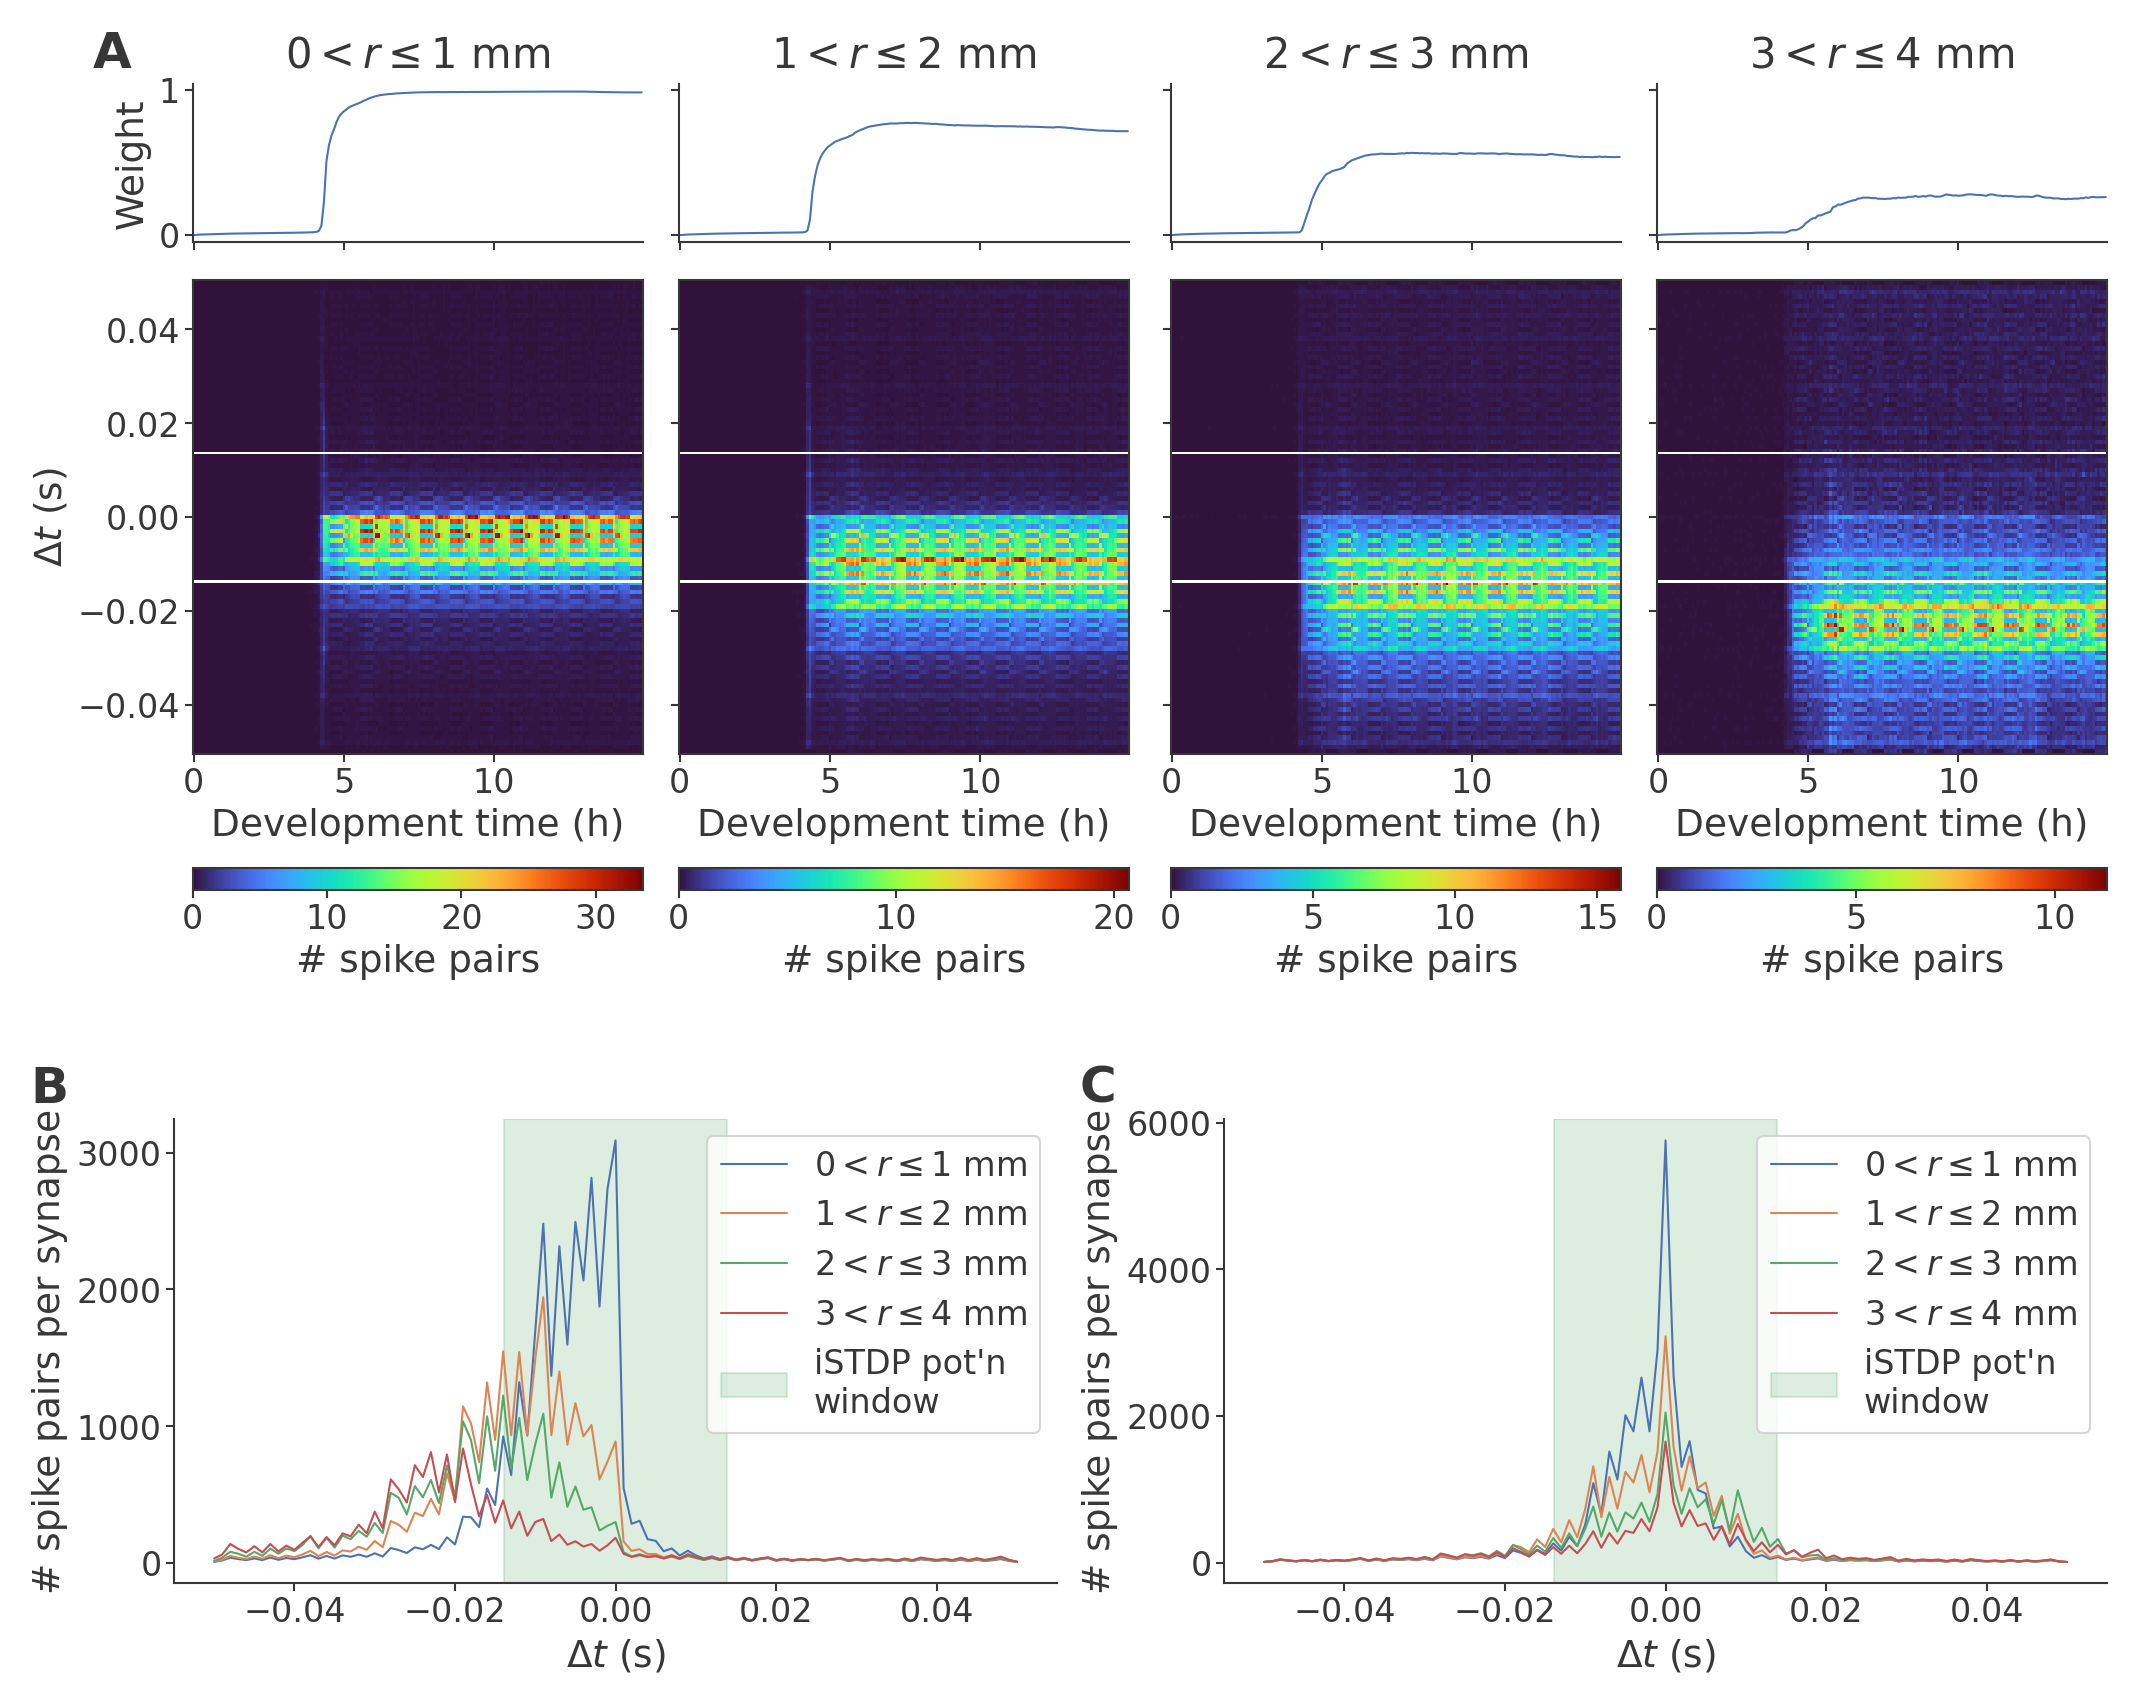

In [13]:
fig = plt.figure(figsize=pu.fullwidth(5), layout='compressed', dpi=300, facecolor='w')
subfigs = fig.subfigures(2, 1, height_ratios=(3,2), hspace=.1)

axs = plot_coincidences(subfigs[0])
pu.label_panel(axs[0,0], 0)

axs = subfigs[1].subplots(1, 2)
plot_coincidence_curves(axs[0], bin_dist_coincidences)
plot_coincidence_curves(axs[1], bin_dist_coincidences_nodelay)
for i, ax in enumerate(axs):
    pu.label_panel(ax, i+1, left=.85)

fig.savefig('Figure 8.tif', bbox_inches='tight')

# Supplement

In [14]:
rp_maxima = np.load(f'{analysis_path}/rp_maxima.npy')
rp_sync_ratios = np.load(f'{analysis_path}/rp_sync_ratios.npy')

WARNING    /tmp/ipykernel_186713/931676547.py:6: RuntimeWarning: Mean of empty slice
  mean_sync_ratio = np.nanmean(rp_sync_ratios, 2)
 [py.warnings]
WARNING    /tmp/ipykernel_186713/931676547.py:7: RuntimeWarning: Mean of empty slice
  mean_maxima = np.nanmean(np.abs(rp_maxima), 2) * 1e3  # s -> ms
 [py.warnings]


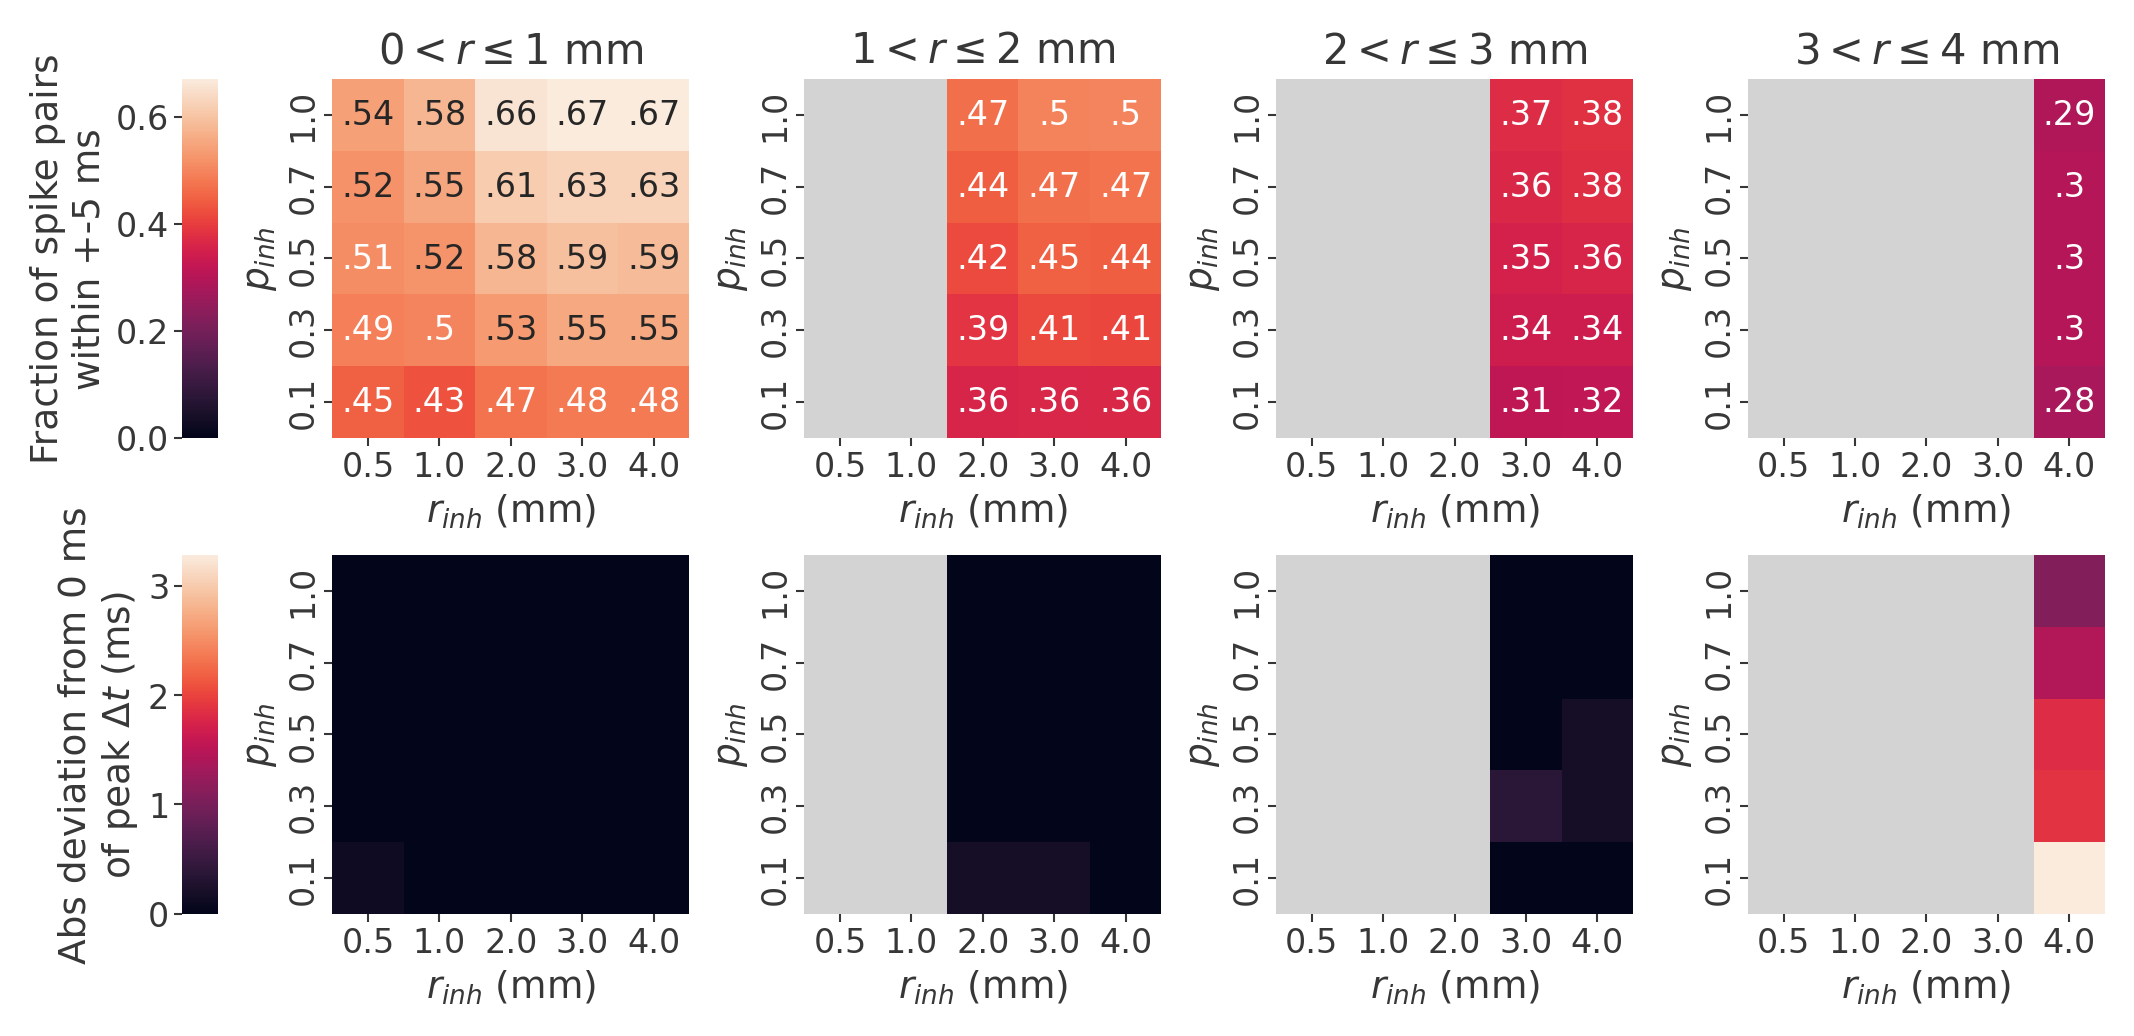

In [15]:
fig, axs = plt.subplots(2, 5, figsize=pu.fullwidth(3), gridspec_kw=dict(width_ratios=(.1,1,1,1,1)), layout='compressed', facecolor='w', dpi=300)

cm = sns.color_palette("rocket", as_cmap=True)
cm.set_bad('lightgrey')

mean_sync_ratio = np.nanmean(rp_sync_ratios, 2)
mean_maxima = np.nanmean(np.abs(rp_maxima), 2) * 1e3  # s -> ms
for i, ax in enumerate(axs.T[1:]):
    annot = [[f'{a:.2g}'.lstrip('0') for a in col] for col in mean_sync_ratio[:, :, i]]
    sns.heatmap(mean_sync_ratio[:,:,i], vmin=0, vmax=np.nanmax(mean_sync_ratio), ax=ax[0], cbar_ax=axs[0,0], annot=annot, fmt='', annot_kws=dict(fontsize=plt.rcParams['xtick.labelsize']), cmap=cm, cbar_kws=dict(location='left'))
    sns.heatmap(mean_maxima[:,:,i], vmin=0, vmax=np.nanmax(mean_maxima), ax=ax[1], cbar_ax=axs[1,0], cmap=cm, cbar_kws=dict(location='left'))
    for ax in ax:
        ax.set_yticks(np.arange(5)+.5, p_list)
        ax.set_xticks(np.arange(5)+.5, r_list)
        ax.set_xlabel('$r_{inh}$ (mm)')
        ax.set_ylabel('$p_{inh}$')
axs[0,0].set_ylabel('Fraction of spike pairs\nwithin +-5 ms')
axs[1,0].set_ylabel('Abs deviation from 0 ms\nof peak $\Delta t$ (ms)')
for i, ax in enumerate(axs[0, 1:]):
    ax.set_title(r_bin_label(i))

fig.savefig('Figure 8.Suppl1.tif', bbox_inches='tight')